In [1]:
import numpy as np
import os
import sys
import torch
from matplotlib import image
import matplotlib.pyplot as plt
import torch.fft as F
from importlib import reload
# sys.path.append('/Users/leonardohuang/Desktop/msu_research/code/')
import utils
from utils import mask_naiveRand

### Use greedy algorithm to select masks for pre-training CNN
- limited success due to extremely slow execution of the greedy algo.

In [6]:
data_path = '/home/huangz78/data/'
data = np.load(data_path+'imgdata.npz')
print(data.files)
imgdata = data['imgdata']
print(imgdata.shape)

['imgdata']
(320, 320, 199)


/opt/anaconda/envs/pyvenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


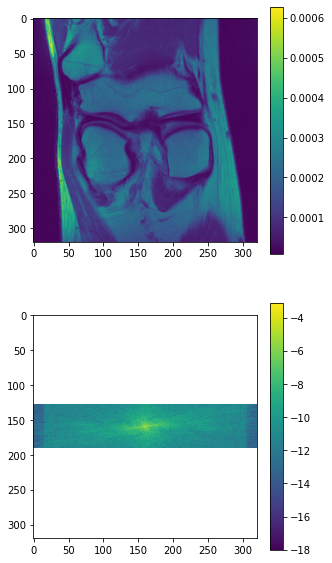

In [7]:
img = imgdata[:,:,8]
imgHeg,imgWid = img.shape[0],img.shape[1]
roll_flag = True
mask,_,_ = mask_naiveRand(imgHeg,fix=int(imgHeg*.2),other=0,roll=roll_flag)
mask = mask.numpy()
yraw = np.fft.fftshift(np.fft.fftn(img,norm='ortho'))
y = np.reshape(np.diag(mask)@yraw,(imgHeg,imgWid,-1)) 

plt.figure(figsize=(5,10))
plt.subplot(211)
plt.imshow(img)
plt.colorbar()

plt.subplot(212)
plt.imshow(np.log(np.abs(y)))
plt.colorbar()
plt.show()

In [8]:
reload(utils)
from utils import mask_naiveRand

In [9]:
from sigpy.mri.app import L1WaveletRecon
from sigpy.mri.app import TotalVariationRecon

- Question: what is the correct input format to use L1WaveletRecon?

    -- ksp roll? assumption: lowest frequency centered
    
    -- mask roll? assumption: lowest frequency centered

### Before running greedy algorithm, want to find out what is the best parameter setting for reconstruction optimization problem
- power of 10 for $\lambda$
    - L1Wavelet: -9,-8.5; 
    - TV: -6.5,-6.3

In [11]:
# single lambda value test
# lamda = 5e-8
from utils import mask_prob
roll_flag = True
mask_rand = mask_prob(img,fix=int(imgHeg*.35),other=int(imgHeg*.1),roll=roll_flag)
mask_freq,_,_ = mask_naiveRand(imgHeg,fix=int(imgHeg*.45),other=0,roll=roll_flag)
# mask_rand = mask_rand.numpy()
mask_freq = mask_freq.numpy()

yraw = np.fft.fftshift(np.fft.fftn(img,norm='ortho'))
y_rand = np.reshape(np.diag(mask_rand)@yraw,(-1,imgHeg,imgWid)) 
y_freq = np.reshape(np.diag(mask_freq)@yraw,(-1,imgHeg,imgWid)) 

# print('yshape = ',y.shape)
# plt.figure()
# plt.title('y')
# plt.imshow(np.log(np.abs(y[:,:,0])))
# plt.show()

# x_ifft = np.real(np.fft.ifftn( np.fft.fftshift(y),norm='ortho' ))
# plt.figure()
# plt.title('ifft recon')
# plt.imshow(x_ifft)
# plt.show()
# err_ifft = np.sqrt( np.sum((x_ifft.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
# print('ifft relative l2 error = ',\
#       np.sqrt( np.sum((x_ifft.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 )))

mps = np.ones((1,imgHeg,imgWid))
# x_recon = np.fft.fftshift(np.real(TotalVariationRecon(ksp, mps, lamda, weights=mask).run()))
# x_recon = np.fft.fftshift(np.real(L1WaveletRecon(ksp, mps, lamda, weights=mask).run()))

lamda = 10**(-6.31)
# x_recon = np.fft.fftshift(np.real(L1WaveletRecon(ksp, mps, lamda).run()))
x_recon_rand = np.fft.fftshift( np.real(TotalVariationRecon(y_rand, mps, lamda,show_pbar=False).run()) )
x_recon_freq = np.fft.fftshift( np.real(TotalVariationRecon(y_freq, mps, lamda,show_pbar=False).run()) )

error_rand = np.sqrt( np.sum((x_recon_rand.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
error_freq = np.sqrt( np.sum((x_recon_freq.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
# error_rand = np.mean(np.abs(x_recon_rand.flatten()-img.flatten())) 
# error_freq = np.mean(np.abs(x_recon_freq.flatten()-img.flatten())) 

print('rand. mask recon. error =',error_rand)
print('low. freq. mask recon. error = ',error_freq)

rand. mask recon. error = 0.042813414602853754
low. freq. mask recon. error =  0.04360785675220906


In [16]:
mps.dtype

dtype('float64')

yshape =  (320, 320, 1)


/Users/leonardohuang/pyvenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


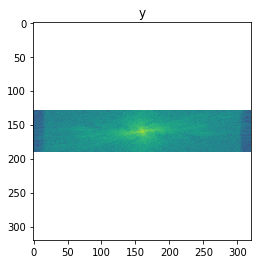

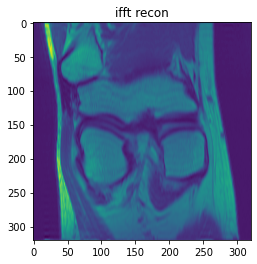

ifft relative l2 error =  0.07082866205458788
iter 1 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 2 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 3 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 4 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 5 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 6 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 7 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 8 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 9 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 10 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 11 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 12 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 13 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 14 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 15 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 16 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 17 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 18 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 19 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

iter 20 out of 20


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
# multiple lambda values test

mask,_,_ = mask_naiveRand(imgHeg,fix=int(imgHeg*.2),other=0,roll=roll_flag)
mask = mask.numpy()
yraw = np.fft.fftshift(np.fft.fftn(img,norm='ortho'))
y = np.reshape(np.diag(mask)@yraw,(imgHeg,imgWid,-1)) 

print('yshape = ',y.shape)
plt.figure()
plt.title('y')
plt.imshow(np.log(np.abs(y[:,:,0])))
plt.show()

x_ifft = np.real(np.fft.ifftn( np.fft.fftshift(y),norm='ortho' ))
plt.figure()
plt.title('ifft recon')
plt.imshow(x_ifft)
plt.show()
err_ifft = np.sqrt( np.sum((x_ifft.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
print('ifft relative l2 error = ',\
      np.sqrt( np.sum((x_ifft.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 )))

ksp = np.moveaxis(y, -1, 0) # Rearranging axes: Loading k-space data in sigpy format
            # Compressive Sensing reconstruction using Sigpy Package
mps = np.ones((1,imgHeg,imgWid))
# x_recon = np.fft.fftshift(np.real(TotalVariationRecon(ksp, mps, lamda, weights=mask).run()))
# x_recon = np.fft.fftshift(np.real(L1WaveletRecon(ksp, mps, lamda, weights=mask).run()))
nGrids = 20
lamda_grid = 10**(np.linspace(-9,-8.5,nGrids) ) # l1wavelet: -9,-8.5; tv: -6.5,-6.3
error      = np.zeros(nGrids)
ind = 0
for lamda in lamda_grid:
    print('iter {0} out of {1}'.format(ind+1,nGrids))
    x_recon = np.fft.fftshift(np.real(L1WaveletRecon(ksp, mps, lamda).run()))
#     x_recon    = np.fft.fftshift( np.real(TotalVariationRecon(ksp, mps, lamda).run()) )
    error[ind] = np.sqrt( np.sum((x_recon.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
    ind += 1

In [57]:
print('opt. power index = ',np.argmin(error))
print('opt. power = ',np.log10(lamda_grid[np.argmin(error)]))
print('opt. lambda val = ',lamda_grid[np.argmin(error)])

opt. power index =  1
opt. power =  -8.526315789473685
opt. lambda val =  2.9763514416313133e-09


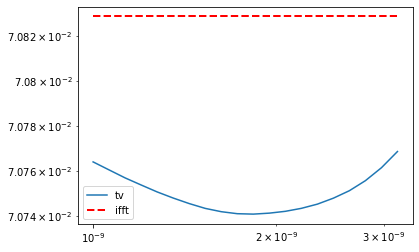

In [62]:
plt.figure()
plt.plot(lamda_grid,error,label='tv')
plt.plot(lamda_grid,err_ifft*np.ones(error.size),'r--', linewidth=2,label='ifft')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
# plt.figure()
# plt.imshow(x_recon)
# plt.show()
# print('Recon relative l2 error = ',\
#       np.sqrt( np.sum((x_recon.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 )))

### Greedy mask select protocol

In [54]:
def greedy_mask_select(x_GT,nlines=16,init_lines=5,lamda=5e-7):
    mps   = np.ones((1,imgHeg,imgWid))
    t0    = time.time()
    N1    = x_GT.shape[0]; N2=x_GT.shape[1]
    mask  = np.zeros((N1,N2))   # Mask to be applied
    lines = np.full(N1, False)  # Lines to be included in mask
    
    # Initializing mask with few lines at the centre
    lines[int(N1/2-init_lines/2):int(N1/2+init_lines/2)] = True; mask[lines] = True
    initial_estimate = np.zeros_like(x_GT)
    line_indices = err_var = iter_time = list([])
    
    yraw = np.fft.fftshift(np.fft.fftn(x_GT,norm='ortho'))    
    for i in range(0,nlines-init_lines): # Iterate over all lines
        print('Iter {0} out of {1}'.format(i+1,nlines-init_lines))
        err = np.full(N1,np.Inf)
        for line in np.nonzero(lines==False)[0]: # Iterate over lines which have not been included yet
            t_i = time.time()
            lines[line] = True
            y = np.reshape(np.diag(lines)@yraw , (-1,N1,N2)) # img size : (1,imgHeg,imgWid)
            x_recon = np.fft.fftshift( np.real(TotalVariationRecon(y, mps, lamda,show_pbar=False).run()) ) # Compressive Sensing reconstruction using Sigpy Package
#             error[ind]   = np.sqrt( np.sum((x_recon.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
            err[line] = np.linalg.norm(x_recon-x_GT)/np.linalg.norm(x_GT) # nRMSE
            lines[line] = False
            print('time elapsed for this line: ',time.time()-t_i)
            
        line_idx = np.argmin(err) # Finding line index with least error
        mask[line_idx,:] = True # Including line in the mask
        lines[line_idx]  = True  # Turning the line ON so that it doesn't get counted again
                    
        line_indices.append(line_idx); err_var.append(np.min(err)); iter_time.append(time.time()-t0)
        print('#lines added:',np.int(np.sum(mask,axis=0)[0]),', line index:',line_idx,', least error:',\
              np.round(np.min(err),2),', Time:', np.round(iter_time[i],2), 'sec')
    return mask, line_indices, err_var, iter_time

In [55]:
import time
mask, line_indices, err_var, iter_time = greedy_mask_select(img,48,32,lamda=5e-7)

Iter 1 out of 16
time elapsed for this line:  3.468079090118408
time elapsed for this line:  3.236146926879883
time elapsed for this line:  3.1753711700439453
time elapsed for this line:  3.1746468544006348
time elapsed for this line:  3.1788017749786377
time elapsed for this line:  3.267825126647949
time elapsed for this line:  3.203434944152832
time elapsed for this line:  3.389069080352783
time elapsed for this line:  3.4289562702178955
time elapsed for this line:  3.375408172607422
time elapsed for this line:  3.4045097827911377
time elapsed for this line:  3.2285566329956055
time elapsed for this line:  3.165674924850464
time elapsed for this line:  3.1824519634246826
time elapsed for this line:  3.1829261779785156
time elapsed for this line:  3.1599879264831543
time elapsed for this line:  3.1810860633850098
time elapsed for this line:  3.1865429878234863
time elapsed for this line:  3.179517984390259
time elapsed for this line:  3.1764919757843018
time elapsed for this line:  3.

KeyboardInterrupt: 

#### Siddhant's code

In [2]:
def greedy_algorithm(y,x_GT,nlines,init_lines,mps,lamda,max_iter,metric):
    t0=time.time()
    N1=y.shape[0];N2=y.shape[1]
    mask=np.zeros((N1,N2)) # Mask to be applied
    lines=np.full(N1, False) # Lines to be included in mask
    
    # Initializing mask with few lines at the centre
    lines[int(N1/2-init_lines/2):int(N1/2+init_lines/2)]=True; mask[lines]=True
    initial_estimate=np.zeros_like(x_GT)
    line_indices=[]; err_var=[]; iter_time=[]
    
    for i in range(0,nlines-init_lines): # Iterate over all lines
        print('Iteration =',i)
        err=np.full(N1,np.Inf)
        
        for line in np.nonzero(lines==False)[0]: # Iterate over lines which have not been included yet
            mask[line,:]=True
            ksp=np.moveaxis(y, -1, 0) # Rearranging axes: Loading k-space data in sigpy format
            # Compressive Sensing reconstruction using Sigpy Package
            x_recon=L1WaveletRecon(ksp, mask, mps, lamda, max_iter, initial_estimate).run()

            # Performance metric:
            if metric=='SSIM':
                err[line] = -ssim(abs(x_GT), abs(x_recon), data_range=abs(x_GT).max() - abs(x_GT).min()) # SSIM
            elif metric=='MSE':
                err[line]=np.linalg.norm(x_recon-x_GT)/np.linalg.norm(x_GT) # nRMSE
            elif metric=='MAE':
                err[line]=np.mean(np.abs(x_recon-x_GT)) # MAE
            elif metric=='HFEN':
                LoG_GT=ndimage.gaussian_laplace(np.real(x_GT), sigma=1)+1j*\
                ndimage.gaussian_laplace(np.imag(x_GT), sigma=1)
                LoG_recon=ndimage.gaussian_laplace(np.real(x_recon), sigma=1)+\
                1j*ndimage.gaussian_laplace(np.imag(x_recon), sigma=1)
                err[line] = np.linalg.norm(log_recon-log_GT)/np.linalg.norm(log_GT) # HFEN
            mask[line,:]=False
            
        line_idx=np.argmin(err) # Finding line index with least error
        mask[line_idx,:]=True # Including line in the mask
        lines[line_idx]=True  # Turning the line ON so that it doesn't get counted again
        
        # Initial estimate for the next iteration
        initial_estimate=L1WaveletRecon(ksp, mask, mps, lamda, max_iter, initial_estimate).run()
            
        line_indices.append(line_idx); err_var.append(np.min(err)); iter_time.append(time.time()-t0)
        print('#lines added:',np.int(np.sum(mask,axis=0)[0]),', line index:',line_idx,', least error:',\
              np.round(np.min(err),2),', Time:', np.round(iter_time[i],2), 'seconds.')
    return mask, line_indices, err_var, iter_time

In [3]:
def greedy_joint_dynamic(y_dynamic,x_GT_dynamic,nlines,init_lines,mps_dynamic,lamda,max_iter,metric):
    t0=time.time()
    N1=y_dynamic.shape[0];N2=y_dynamic.shape[1];
    N_frames=y_dynamic.shape[3]
    mask=np.zeros((N1,N2)) # Mask to be applied
    lines=np.full(N1, False) # Lines to be included in mask
    lines[int(N1/2-init_lines/2):int(N1/2+init_lines/2)]=True; 
    mask[lines]=True # Initializing mask with few lines at the centre
    initial_estimate=np.zeros((N1,N2),dtype='complex')
    
    line_indices=[]; err_var=[]; iter_time=[]
    for i in range(0,nlines-init_lines): # Iterate over all lines
        print('Iteration =',i)
        err=np.full(N1,np.Inf)
        
        for line in np.nonzero(lines==False)[0]: # Iterate over lines which have not been included yet
            mask[line,:]=True
            err_fr=np.zeros((N_frames))
            for ph in range(0,N_frames):
                y=y_dynamic[:,:,:,ph]; x_GT=x_GT_dynamic[:,:,ph]; mps=mps_dynamic[:,:,:,ph]
                ksp=np.moveaxis(y, -1, 0) # Reaaranging axes: Loading k-space data in sigpy format
                x_recon=L1WaveletRecon(ksp, mask, mps, lamda, max_iter, initial_estimate).run() # CS reconstruction
           
                # Performance metric:
                if metric=='SSIM':
                    err_fr[ph] = -ssim(abs(x_GT), abs(x_recon), data_range=abs(x_GT).max() - abs(x_GT).min()) # SSIM
                elif metric=='MSE':
                    err_fr[ph]=np.mean(np.abs(x_recon-x_GT)**2) # MSE
                elif metric=='MAE':
                    err_fr[ph]=np.mean(np.abs(x_recon-x_GT)) # MAE
                elif metric=='HFEN':
                    LoG_GT=ndimage.gaussian_laplace(np.real(x_GT), sigma=1)+1j*\
                    ndimage.gaussian_laplace(np.imag(x_GT), sigma=1)
                    LoG_recon=ndimage.gaussian_laplace(np.real(x_recon), sigma=1)+\
                    1j*ndimage.gaussian_laplace(np.imag(x_recon), sigma=1)
                    err_fr[ph] = np.linalg.norm(log_recon-log_GT)/np.linalg.norm(log_GT) # HFEN
                    
            mask[line,:]=False
            err[line]=np.mean(err_fr)
        line_idx=np.argmin(err) # Finding line index with least error
        mask[line_idx,:]=True # Including line in the mask
        lines[line_idx]=True  # Turning the line ON so that it doesn't get counted again
                
        line_indices.append(line_idx); err_var.append(np.min(err)); iter_time.append(time.time()-t0)
        np.savez('ocmr_sigpy_joint_dynamic',mask,line_indices,err_var,iter_time,i)
        print('#lines added =',np.sum(mask,axis=0)[0],', line index =',line_idx,', least error =',np.round(np.min(err),2),\
              ', Time=', np.round(iter_time[i],2), 'seconds.')
    return mask, line_indices, err_var, iter_time

### arxived reconstructor from class material

In [ ]:
import pywt
class Linop(object):
    def __call__(self, x):
        return self._forward(x)
    
    def H(self, x):
        return self._adjoint(x)
    
    def __mul__(self, B):
        return Compose(self, B)
    
    def _forward(self, x):
        raise NotImplementedError

    def _adjoint(self, x):
        raise NotImplementedError
        
class Compose(Linop):
    def __init__(self, A, B):
        self.A = A
        self.B = B
        
    def _forward(self, x):
        return self.A(self.B(x))
    
    def _adjoint(self, x):
        return self.B.H(self.A.H(x))
    
class FFTLinop(Linop):
    
    def _forward(self, x):
        y = np.fft.ifftshift(x)
        y = np.fft.fftn(y, norm='ortho')
        y = np.fft.fftshift(y)
        return y

    def _adjoint(self, x):
        y = np.fft.ifftshift(x)
        y = np.fft.ifftn(y, norm='ortho')
        y = np.fft.fftshift(y)
        return y

class SamplingLinop(Linop):

    def _forward(self, x):
        return mask * x

    _adjoint = _forward

class InverseWaveletLinop(Linop):

    def _forward(self, x):
        y = pywt.array_to_coeffs(x, coeff_slices)
        y = pywt.waverecn(y, 'db4', mode='periodic')
        return y

    def _adjoint(self, x):
        coeff = pywt.wavedecn(x, 'db4', mode='periodic', level=3)
        coeff, coeff_slices = pywt.coeffs_to_array(coeff)
        return coeff

def soft_thresh(z, lamda):
    mag = np.abs(z) - lamda
    mag *= mag > 0
    
    sign = np.divide(z, np.abs(z), where=np.abs(z) != 0)
    return mag * sign


max_iterations = 200  # number of iterations of proximal gradient descent
alpha = 1e-1 # 0.1    # step size
lamda = 5e-8 
def L1WaveletRecon(ksp,lamda=5e-8, alpha=1e-1, max_iter=200):
    F = FFTLinop()
    S = SamplingLinop()
    mask = np.abs(ksp) > 0
    W = InverseWaveletLinop()
    A = S * F * W
    coeff_hat = np.zeros_like(coeff).astype(ksp.dtype)  #initial sparse coefficients
    for it in range(max_iterations):
        coeff_hat -= alpha * A.H(A(coeff_hat) - ksp)
        coeff_hat = soft_thresh(coeff_hat, lamda * alpha)

    #How do you get the image from the reconstructed wavelet coefficients?
    img_hat = W(coeff_hat)

return img_hat

#### Enter Answer Below ####
fig, ax = plt.subplots()
ax.imshow(np.abs(img), cmap='gray')#, vmax=1)
ax.set_title('Ground Truth')

fig, ax = plt.subplots()
ax.imshow(np.abs(img_r), cmap='gray')#, vmax=1)
ax.set_title('Inverse FFT Reconstruction')

fig, ax = plt.subplots()
ax.imshow(np.abs(img_hat), cmap='gray')#, vmax=1)
ax.set_title('Wavelet Sparsity Regularized Reconstruction')

print('RMSE of the inverse FFT reconstruction is', RMSE(img_r,img), 'and the RMSE of the l1 reconstruction is', RMSE(img_hat,img))